In [127]:
# IMPORTS

from waffles.data_classes.WaveformSet import *
from waffles.data_classes.Waveform import *
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
from pathlib import Path

from scipy.fft import fft, fftshift # For the deconvolution

from waffles.utils.baseline.baseline import SBaseline # Baseline computation from Henrique

In [ ]:
# FUNCTIONS

def channel_filter(waveform : Waveform, end : int, ch : int) -> bool:
    if (waveform.channel == ch) and (waveform.endpoint == end) :
        return True
    else:
        return False
    
def beam_self_trigger_filter(waveform : Waveform, timeoffset_min : int = -120, timeoffset_max : int = -90) -> bool:
    daq_pds_timeoffset = np.float32(np.int64(waveform.timestamp)-np.int64(waveform.daq_window_timestamp))
    if (daq_pds_timeoffset < timeoffset_max) and (daq_pds_timeoffset > timeoffset_min) :
        return True
    else:
        return False

def run_filter(waveform : Waveform, run : int) -> bool:
    if (waveform.run_number == run):
        return True
    else:
        return False

def fbk_or_hpk(endpoint: int, channel: int):
    channel_vendor_map = {
    104: {0: "FBK", 1: "FBK", 2: "FBK", 3: "FBK", 4: "FBK", 5: "FBK", 6: "FBK", 7: "FBK",
          10: "HPK", 11: "HPK", 12: "HPK", 13: "HPK", 14: "HPK", 15: "HPK", 16: "HPK", 17: "HPK"},
    105: {0: "FBK", 1: "FBK", 2: "FBK", 3: "FBK", 4: "FBK", 5: "FBK", 6: "FBK", 7: "FBK",
          10: "FBK", 12: "FBK", 15: "FBK", 17: "FBK", 21: "HPK", 23: "HPK", 24: "HPK", 26: "HPK"},
    107: {0: "FBK", 2: "FBK", 5: "FBK", 7: "FBK",
          10: "HPK", 12: "HPK", 15: "HPK", 17: "HPK"},
    109: {0: "FBK", 1: "FBK", 2: "FBK", 3: "FBK", 4: "FBK", 5: "FBK", 6: "FBK", 7: "FBK",
          10: "FBK", 11: "FBK", 12: "FBK", 13: "FBK", 14: "FBK", 15: "FBK", 16: "FBK", 17: "FBK",
          20: "HPK", 21: "HPK", 22: "HPK", 23: "HPK", 24: "HPK", 25: "HPK", 26: "HPK", 27: "HPK",
          30: "HPK", 31: "HPK", 32: "HPK", 33: "HPK", 34: "HPK", 35: "HPK", 36: "HPK", 37: "HPK",
          40: "HPK", 41: "HPK", 42: "HPK", 43: "HPK", 44: "HPK", 45: "HPK", 46: "HPK", 47: "HPK"},
    111: {0: "FBK", 1: "FBK", 2: "FBK", 3: "FBK", 4: "FBK", 5: "FBK", 6: "FBK", 7: "FBK",
          10: "FBK", 11: "FBK", 12: "FBK", 13: "FBK", 14: "FBK", 15: "FBK", 16: "FBK", 17: "FBK",
          20: "FBK", 21: "FBK", 22: "FBK", 23: "FBK", 24: "FBK", 25: "FBK", 26: "FBK", 27: "FBK",
          30: "HPK", 31: "HPK", 32: "HPK", 33: "HPK", 34: "HPK", 35: "HPK", 36: "HPK", 37: "HPK",
          40: "HPK", 41: "HPK", 42: "HPK", 43: "HPK", 44: "HPK", 45: "HPK", 46: "HPK", 47: "HPK"},
    112: {0: "HPK", 1: "HPK", 2: "HPK", 3: "HPK", 4: "HPK", 5: "HPK", 6: "HPK", 7: "HPK",
          10: "HPK", 11: "HPK", 12: "HPK", 13: "HPK", 14: "HPK", 15: "HPK", 16: "HPK", 17: "HPK",
          20: "HPK", 21: "HPK", 22: "HPK", 23: "HPK", 24: "HPK", 25: "HPK", 26: "HPK", 27: "HPK",
          30: "HPK", 31: "HPK", 32: "HPK", 33: "HPK", 34: "HPK", 35: "HPK", 36: "HPK", 37: "HPK",
          40: "HPK", 42: "HPK", 45: "HPK", 47: "HPK"},
    113: {0: "FBK", 2: "FBK", 5: "FBK", 7: "FBK"}}

    return channel_vendor_map[endpoint][channel]

In [129]:
# INPUT DATA 
NP04_wfset_filepath = f"/afs/cern.ch/work/a/anbalbon/public/np04_beam_pickles/set_A/set_A_self_beam_50files109.pkl"
maritza_template_folder = '/afs/cern.ch/work/a/anbalbon/public/template_larsoft'
Larsoft_daphne_channel_map_path = '/afs/cern.ch/work/a/anbalbon/public/template_larsoft/PDHD_PDS_ChannelMap.csv' #By federico


# CHANNEL SELECTION
apa = 2
endpoint = 109
daq_channel = 7 
n_wf = 12
vendor = fbk_or_hpk(endpoint,daq_channel)

# GAUSSIAN FILTER
sigma = 25

Reading waveform pickles file...
done

Beam event and channel section...
done

Waveform selection and plotting...


Text(0, 0.5, 'Amplitude')

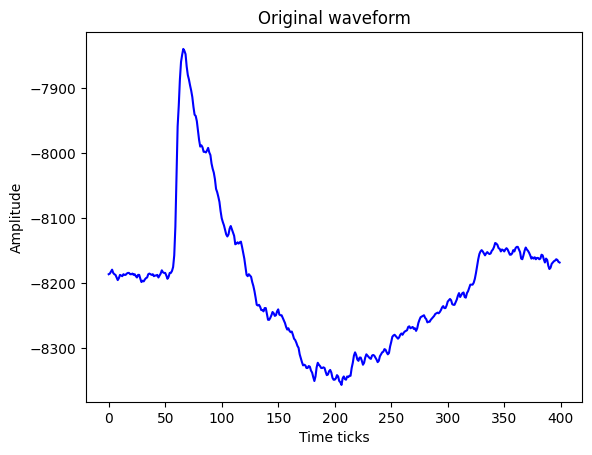

In [130]:
print('Reading waveform pickles file...')
with open(NP04_wfset_filepath, 'rb') as f:
    wfset = pickle.load(f) 
    print('done\n')

print('Beam event and channel section...')    
my_wfset = WaveformSet.from_filtered_WaveformSet(WaveformSet.from_filtered_WaveformSet(wfset, beam_self_trigger_filter), channel_filter, end=endpoint, ch=daq_channel)
print('done\n')

print('Waveform selection and plotting...')   
my_waveform = my_wfset.waveforms[n_wf]
waveform_adcs = -1 * my_waveform.adcs.astype(np.int16)
plt.figure()
plt.title('Original waveform')
plt.plot(waveform_adcs[0:400], color = 'blue')
plt.xlabel('Time ticks')
plt.ylabel('Amplitude')

Baseline evaluation status: True
Value: 8186.785661969866
Removing baseline...


Text(0, 0.5, 'Amplitude')

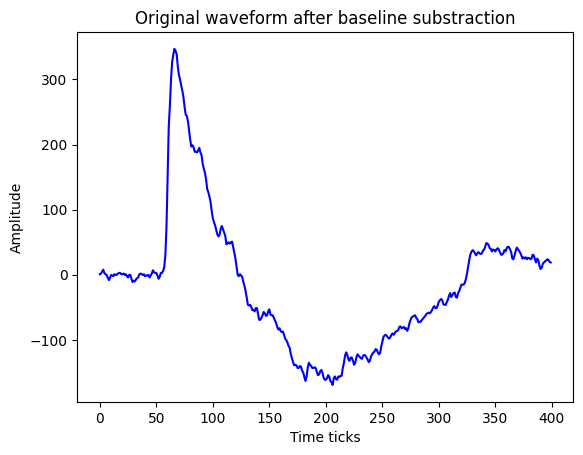

In [131]:
# BASELINE (from henrique)
baseliner = SBaseline()
baseliner.binsbase       = np.linspace(0,2**14-1,2**14)
baseliner.threshold      = 6
baseliner.wait           = 25
baseliner.minimumfrac    = 0.166666
baseliner.baselinestart  = 0
baseliner.baselinefinish = 50

base, optimal = baseliner.wfset_baseline(my_waveform)
print(f"Baseline evaluation status: {optimal}\nValue: {base}")

print("Removing baseline...")
new_wf_adcs = my_waveform.adcs
new_wf_adcs = -( new_wf_adcs.astype(float) - base)

plt.figure()
plt.title('Original waveform after baseline substraction')
plt.plot(new_wf_adcs[:400], color='blue', label = 'original')
plt.xlabel('Time ticks')
plt.ylabel('Amplitude')

In [132]:
#filter
# w = np.ones(5)
# new_waveforms_adcs = np.convolve(waveform_adcs,w,"valid")
# plt.plot(new_waveforms_adcs[5:-5])

# COSA FA??????

Searchig for maritza template...
Plotting template...


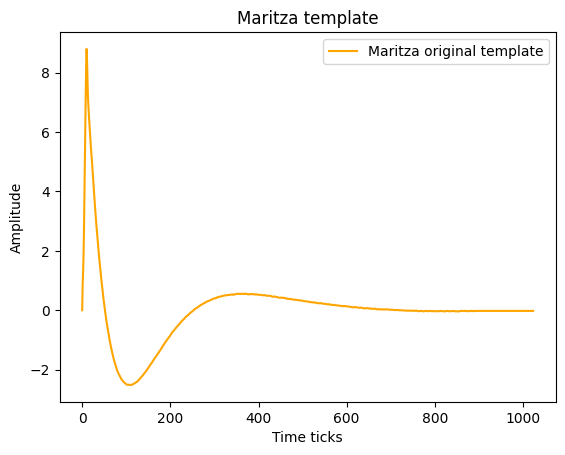

In [ ]:
#MARITZA TEMPLATE
print('Searchig for maritza template...')
df = pd.read_csv(Larsoft_daphne_channel_map_path, sep=",")
daphne_channels = df['daphne_ch'].values + 100*df['endpoint'].values
daphne_to_offline = dict(zip(daphne_channels, df['offline_ch'])) 
offline_to_daphne = dict(zip(df['offline_ch'],daphne_channels))
daphne_channel = daq_channel + 100*endpoint #SOno daq!!
apa_template_folder  = next((f for f in Path(maritza_template_folder).glob("*APA2*") if f.is_dir()), None)
if apa_template_folder:
    martiza_template_file = next(apa_template_folder.glob(f"*APA{apa}_CH{daphne_to_offline[daphne_channel]}*.txt"), None)
    if martiza_template_file:
        with open(martiza_template_file, "r") as file:
            maritza_values = [float(line.strip()) for line in file]
            
        print('Plotting template...')
        maritza_template = np.array(maritza_values)
        plt.figure()
        plt.title('Maritza template')
        plt.plot(maritza_template,label='Maritza original template', color='orange')       
        plt.legend()
        plt.xlabel('Time ticks')
        plt.ylabel('Amplitude')
        
    else:
        print('File not found')
else:
    print("Template folder not found")


/afs/cern.ch/user/a/anbalbon/virtual_env/daq_env/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/afs/cern.ch/user/a/anbalbon/virtual_env/daq_env/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


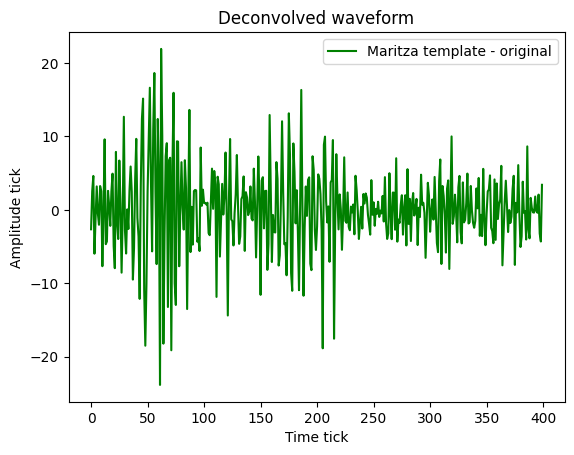

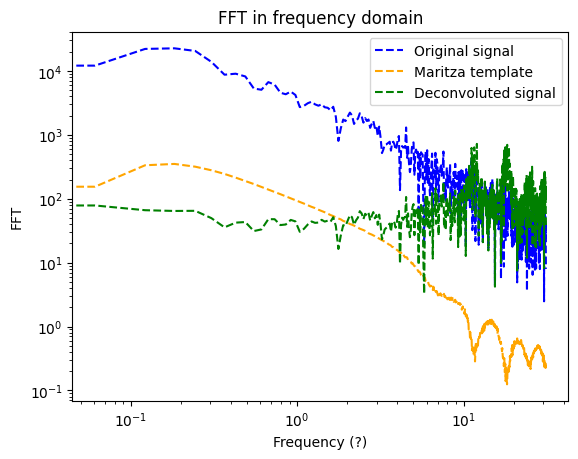

In [134]:
# FIRST ROUGH DECONVOLUTION - Maritza
# No filter 

if martiza_template_file:
    signal_fft = np.fft.fft(new_wf_adcs)
    
    martiza_template_fft = np.fft.fft(maritza_template, n=len(new_wf_adcs))  
    martiza_deconvolved_fft = signal_fft/ (martiza_template_fft )     
    martiza_deconvolved_wf = np.fft.ifft(martiza_deconvolved_fft) 
    
    plt.figure()     
    plt.title('Deconvolved waveform')
    plt.plot(martiza_deconvolved_wf[0:400], label = 'Maritza template - original', color = 'green')
    plt.xlabel('Time tick')
    plt.ylabel('Amplitude tick')
    plt.legend()

    plt.figure() 
    plt.title('FFT in frequency domain')
    frequencies = np.fft.fftfreq(1024, d=16*1e-9*1e+6)[:1024//2+1] # Depending on DAPHNE rate
    frequencies[-1] = -frequencies[-1]
    plt.plot(frequencies,(np.abs(signal_fft))[0:int(1024/2+1)],linestyle="--", label='Original signal', color = 'blue')
    plt.plot(frequencies,(np.abs(martiza_template_fft))[0:int(1024/2+1)],linestyle="--", label='Maritza template', color = 'orange')
    plt.plot(frequencies,(np.abs(martiza_deconvolved_fft))[0:int(1024/2+1)],linestyle="--", label='Deconvoluted signal', color = 'green')
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel('Frequency (?)')
    plt.ylabel('FFT')
    plt.legend()


Applying gaussian filter (in frequency domain)...


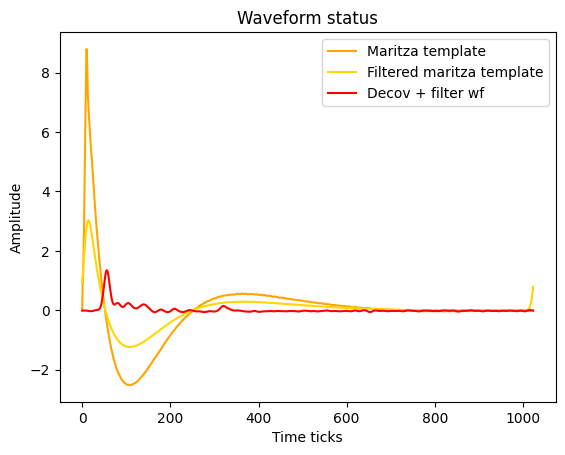

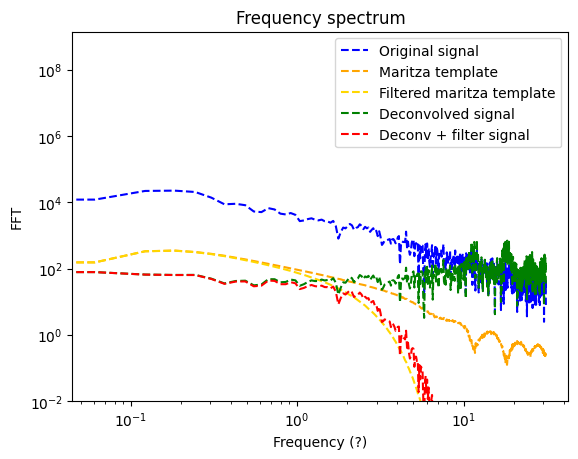

In [135]:
# SECOND DECONVOLUTION - Maritza
# Gaussian filter 

def gaus(x, sigma=20):
    return np.exp(-(x)**2/2/sigma**2)
_x = np.linspace(0, 1024, 1024, endpoint=False)
filter_gaus = [ gaus(x,sigma=sigma) for x in _x]

if martiza_template_file:
    # Orignal deconvolution (as before)...
    signal_fft = np.fft.fft(new_wf_adcs)
    martiza_template_fft = np.fft.fft(maritza_template, n=len(new_wf_adcs))
    martiza_deconvolved_fft = signal_fft/ (martiza_template_fft)    
    martiza_deconvolved_wf = np.fft.ifft(martiza_deconvolved_fft) 

    print('Applying gaussian filter (in frequency domain)...')
    filtered_martiza_deconvolved_fft = martiza_deconvolved_fft.copy()
    for j, _ in enumerate(filtered_martiza_deconvolved_fft):
        filtered_martiza_deconvolved_fft[j] *= filter_gaus[j]
    filtered_martiza_deconvolved_wf = np.fft.ifft(filtered_martiza_deconvolved_fft)   
    
    filtered_martiza_template_fft = martiza_template_fft.copy()
    for j, _ in enumerate(filtered_martiza_template_fft):
        filtered_martiza_template_fft[j] *= filter_gaus[j]
    filtered_martiza_template = np.fft.ifft(filtered_martiza_template_fft)   

    ## offset_of_template = get_offset(other_template)
    ## offset_of_response = get_offset(new_wf_adcs)
    # offset _of_template = 60
    # offset_of_response = 145
    # shifted_filtered_martiza_deconvolved_aux = np.roll(filtered_martiza_deconvolved_aux, offset_of_response)

    plt.figure()
    plt.title('Waveform status')
    #plt.plot(new_wf_adcs, color = 'blue', label='Original NP04 wf') 
    plt.plot(maritza_template, color = 'orange', label='Maritza template')
    plt.plot(filtered_martiza_template, color = 'gold', label='Filtered maritza template')
    plt.plot(filtered_martiza_deconvolved_wf, color = 'red', label = 'Decov + filter wf')
    plt.xlabel('Time ticks')
    plt.ylabel('Amplitude')
    plt.legend()
    #plt.xlim(0,150)

    frequencies = np.fft.fftfreq(1024, d=16*1e-9*1e+6)[:1024//2+1]
    frequencies[-1] = -frequencies[-1]
    plt.figure()
    plt.title('Frequency spectrum')
    plt.plot(frequencies,(np.abs(signal_fft))[0:int(1024/2+1)],color = 'blue', linestyle="--", label='Original signal')
    plt.plot(frequencies,(np.abs(martiza_template_fft))[0:int(1024/2+1)],color = 'orange', linestyle="--", label='Maritza template')
    plt.plot(frequencies,(np.abs(filtered_martiza_template_fft))[0:int(1024/2+1)],color = 'gold', linestyle="--", label='Filtered maritza template')
    plt.plot(frequencies,(np.abs(martiza_deconvolved_fft))[0:int(1024/2+1)], color = 'green', linestyle="--", label='Deconvolved signal')
    plt.plot(frequencies,(np.abs(filtered_martiza_deconvolved_fft))[0:int(1024/2+1)],color = 'red', linestyle="--", label='Deconv + filter signal')
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel('Frequency (?)')
    plt.ylabel('FFT')
    plt.ylim(1e-2,None)
    plt.legend() 


Plotting template...


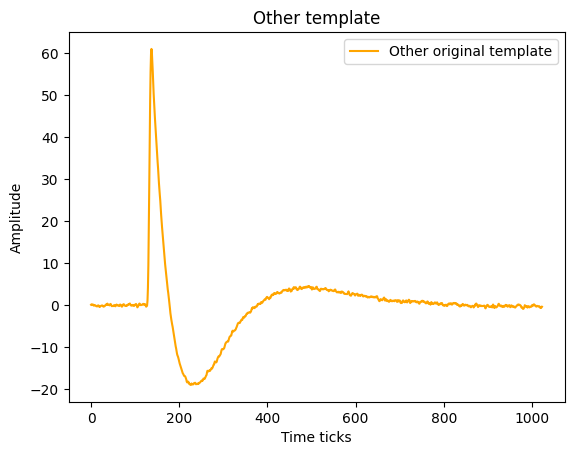

In [136]:
# OTHER TEMPLATES 
other_template = '/afs/cern.ch/work/a/anbalbon/private/waffles/src/waffles/np04_analysis/tau_slow_convolution/output/templates/template_run028489_ch10907_avg.pkl'

with open(other_template, 'rb') as f:
    wfset = pickle.load(f)

if len(other_template)>0:
    with open(f"{other_template}", "rb") as file:
        other_values = (pickle.load(file))[0]

    print('Plotting template...')
    other_template = np.array(other_values) 
    plt.figure()
    plt.title('Other template')
    plt.plot(other_template,label='Other original template', color='orange')       
    plt.legend()
    plt.xlabel('Time ticks')
    plt.ylabel('Amplitude')


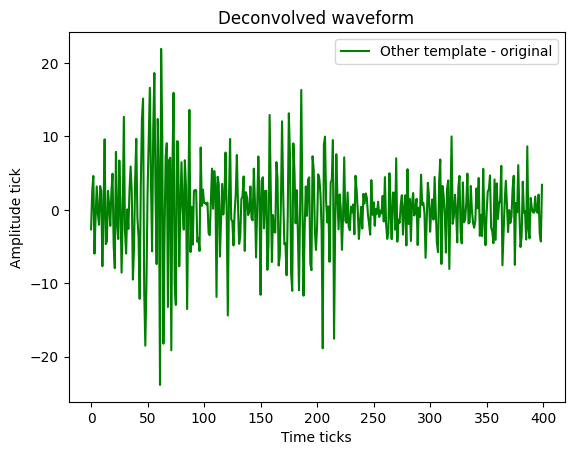

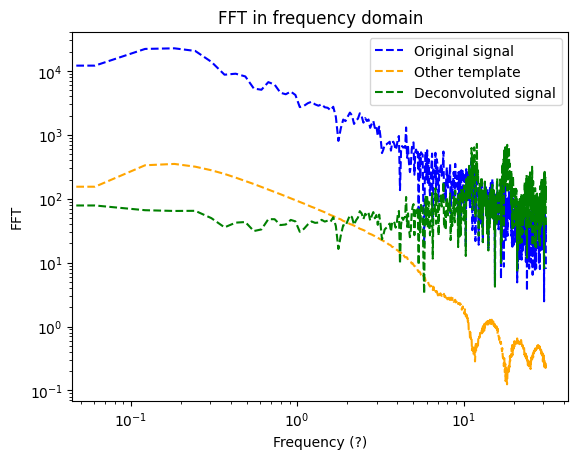

In [137]:
# FIRST ROUGH DECONVOLUTION - Other
# No filter 

if len(other_template)>0:
    signal_fft = np.fft.fft(new_wf_adcs)
    
    other_template_fft = np.fft.fft(maritza_template, n=len(new_wf_adcs))  
    other_deconvolved_fft = signal_fft/ (other_template_fft )     
    other_deconvolved_wf = np.fft.ifft(other_deconvolved_fft) 
    
    plt.figure()     
    plt.title('Deconvolved waveform')
    plt.plot(other_deconvolved_wf[0:400], label = 'Other template - original', color = 'green')
    plt.xlabel('Time ticks')
    plt.ylabel('Amplitude tick')
    plt.legend()

    plt.figure() 
    plt.title('FFT in frequency domain')
    frequencies = np.fft.fftfreq(1024, d=16*1e-9*1e+6)[:1024//2+1] # Depending on DAPHNE rate
    frequencies[-1] = -frequencies[-1]
    plt.plot(frequencies,(np.abs(signal_fft))[0:int(1024/2+1)],linestyle="--", label='Original signal', color = 'blue')
    plt.plot(frequencies,(np.abs(other_template_fft))[0:int(1024/2+1)],linestyle="--", label='Other template', color = 'orange')
    plt.plot(frequencies,(np.abs(other_deconvolved_fft))[0:int(1024/2+1)],linestyle="--", label='Deconvoluted signal', color = 'green')
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel('Frequency (?)')
    plt.ylabel('FFT')
    plt.legend()

Applying gaussian filter (in frequency domain)...


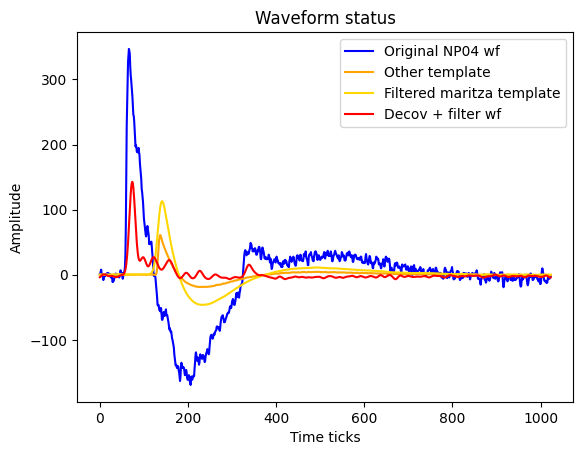

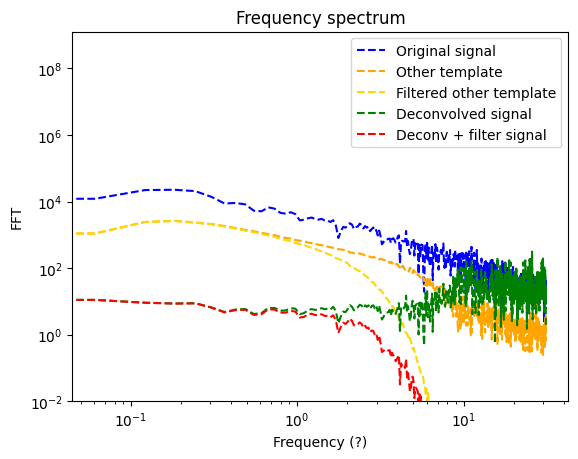

In [138]:
# SECOND DECONVOLUTION - Other
# Gaussian filter 


def gaus(x, sigma=20):
    return np.exp(-(x)**2/2/sigma**2)
_x = np.linspace(0, 1024, 1024, endpoint=False)
filter_gaus = [ gaus(x,sigma=sigma) for x in _x]


if len(other_template)>0:
    # Orignal deconvolution (as before)...
    signal_fft = np.fft.fft(new_wf_adcs)
    other_template_fft = np.fft.fft(other_template, n=len(new_wf_adcs))
    other_deconvolved_fft = signal_fft/ (other_template_fft)    
    other_deconvolved_wf = np.fft.ifft(other_deconvolved_fft) 

    print('Applying gaussian filter (in frequency domain)...')
    filtered_other_deconvolved_fft = other_deconvolved_fft.copy()
    for j, _ in enumerate(filtered_other_deconvolved_fft):
        filtered_other_deconvolved_fft[j] *= filter_gaus[j]
    filtered_other_deconvolved_wf = np.fft.ifft(filtered_other_deconvolved_fft)   
    
    filtered_other_template_fft = other_template_fft.copy()
    for j, _ in enumerate(filtered_other_template_fft):
        filtered_other_template_fft[j] *= filter_gaus[j]
    filtered_other_template = np.fft.ifft(filtered_other_template_fft)   

    ## offset_of_template = get_offset(other_template)
    ## offset_of_response = get_offset(new_wf_adcs)
    offset_of_template = 60
    offset_of_response = 145
    filtered_other_deconvolved_wf = np.roll(filtered_other_deconvolved_wf, offset_of_response)

    plt.figure()
    plt.title('Waveform status')
    plt.plot(new_wf_adcs, color = 'blue', label='Original NP04 wf') 
    plt.plot(other_template, color = 'orange', label='Other template')
    plt.plot(filtered_other_template*5, color = 'gold', label='Filtered maritza template')
    plt.plot(filtered_other_deconvolved_wf*800, color = 'red', label = 'Decov + filter wf')
    plt.xlabel('Time ticks')
    plt.ylabel('Amplitude')
    plt.legend()
    #plt.xlim(0,150)

    frequencies = np.fft.fftfreq(1024, d=16*1e-9*1e+6)[:1024//2+1]
    frequencies[-1] = -frequencies[-1]
    plt.figure()
    plt.title('Frequency spectrum')
    plt.plot(frequencies,(np.abs(signal_fft))[0:int(1024/2+1)],color = 'blue', linestyle="--", label='Original signal')
    plt.plot(frequencies,(np.abs(other_template_fft))[0:int(1024/2+1)],color = 'orange', linestyle="--", label='Other template')
    plt.plot(frequencies,(np.abs(filtered_other_template_fft))[0:int(1024/2+1)],color = 'gold', linestyle="--", label='Filtered other template')
    plt.plot(frequencies,(np.abs(other_deconvolved_fft))[0:int(1024/2+1)], color = 'green', linestyle="--", label='Deconvolved signal')
    plt.plot(frequencies,(np.abs(filtered_other_deconvolved_fft))[0:int(1024/2+1)],color = 'red', linestyle="--", label='Deconv + filter signal')
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel('Frequency (?)')
    plt.ylabel('FFT')
    plt.ylim(1e-2,None)
    plt.legend() 

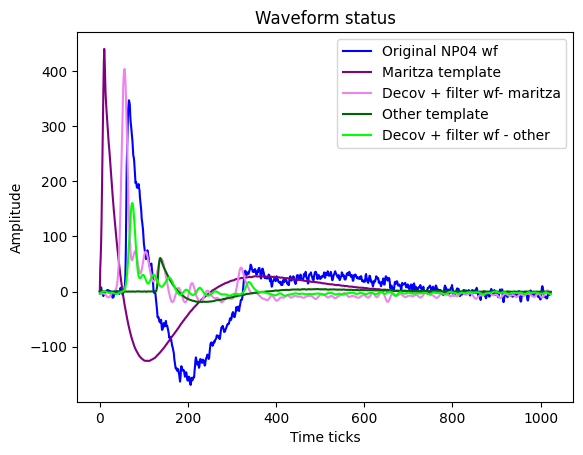

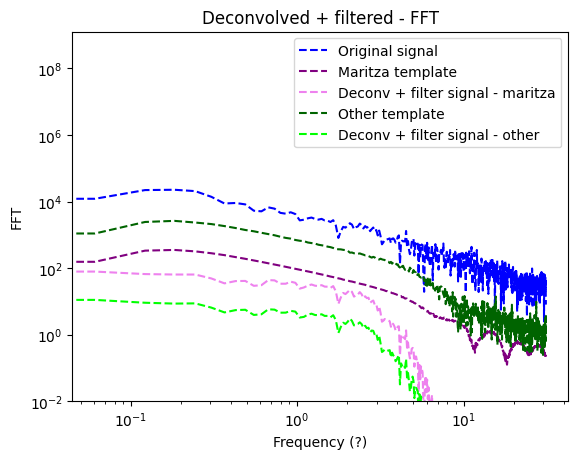

In [139]:
# TEMPLATE COMPARISON

if len(other_template)>0 and martiza_template_file:
    plt.figure()
    plt.title('Waveform status')
    plt.plot(new_wf_adcs, color = 'blue', label='Original NP04 wf') 
    plt.plot(maritza_template*50, color = 'purple', label='Maritza template')
    plt.plot(filtered_martiza_deconvolved_wf*300, color = 'violet', label = 'Decov + filter wf- maritza')
    plt.plot(other_template, color = 'darkgreen', label='Other template')
    plt.plot(filtered_other_deconvolved_wf*900, color = 'lime', label = 'Decov + filter wf - other')
    plt.xlabel('Time ticks')
    plt.ylabel('Amplitude')
    plt.legend()
    #plt.xlim(0,150)
        

    
    plt.figure()
    plt.title('Deconvolved + filtered - FFT')
    plt.plot(frequencies,(np.abs(signal_fft))[0:int(1024/2+1)],color = 'blue', linestyle="--", label='Original signal')
    plt.plot(frequencies,(np.abs(martiza_template_fft))[0:int(1024/2+1)],color = 'purple', linestyle="--", label='Maritza template')
    plt.plot(frequencies,(np.abs(filtered_martiza_deconvolved_fft))[0:int(1024/2+1)],color = 'violet', linestyle="--", label='Deconv + filter signal - maritza')
    plt.plot(frequencies,(np.abs(other_template_fft))[0:int(1024/2+1)],linestyle="--", label='Other template', color = 'darkgreen')
    plt.plot(frequencies,(np.abs(filtered_other_deconvolved_fft))[0:int(1024/2+1)],color = 'lime', linestyle="--", label='Deconv + filter signal - other')
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel('Frequency (?)')
    plt.ylabel('FFT')
    plt.ylim(1e-2,None)
    plt.legend() 

94.61148819979421


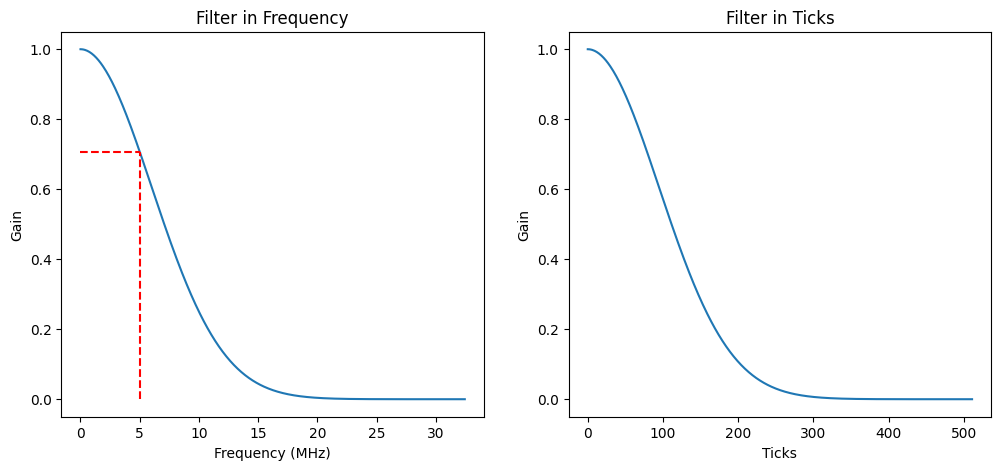

In [140]:
import numpy as np
import matplotlib.pyplot as plt

def gauss_filter(x, sigma):
    return np.exp(-0.5 * (x/sigma)**2)

# Imposta direttamente il valore di cutoff
fc = 5.0

npoints = 1024//2  # La FFT ha metà della lunghezza delle forme d'onda
FFTFreq = 32.5  # Frequenza della FFT in MHz

binwidth = FFTFreq / npoints  # Ogni bin della FFT ha una larghezza di binwidth in MHz

x_freq = np.linspace(0, FFTFreq, npoints, endpoint=False)
x_tick = np.linspace(0, npoints, npoints, endpoint=False)

# ---- Se si lavora con la frequenza ----
gaussian_stddev = fc / np.sqrt(np.log(2))

# In frequenza
y_freq = [gauss_filter(i, gaussian_stddev) for i in x_freq]
y_freq = [gauss_filter(i * binwidth, gaussian_stddev) for i in x_tick]

# ---- Se si lavora con i ticks ----
fc_in_ticks = fc / binwidth
gaussian_stddev_in_ticks = fc_in_ticks / np.sqrt(np.log(2))
print(gaussian_stddev_in_ticks)
# In ticks
y_ticks = [gauss_filter(i, gaussian_stddev_in_ticks) for i in x_tick]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(x_freq, y_freq)
ax[0].vlines(fc, 0, 1/np.sqrt(2), color='r', linestyle='--')
ax[0].hlines(1/np.sqrt(2), 0, fc, color='r', linestyle='--')
ax[0].set_title('Filter in Frequency')
ax[0].set_xlabel('Frequency (MHz)')
ax[0].set_ylabel('Gain')

ax[1].plot(x_tick, y_ticks)
ax[1].set_title('Filter in Ticks')
ax[1].set_xlabel('Ticks')
ax[1].set_ylabel('Gain')

plt.show()


In [141]:
# GAUSSIAN FILTER

## if you know sigma
sigma = 25
cutoff_freq = sigma * np.sqrt(np.log(2))
print(f"Sigma = {sigma} corresponds to cutoff = {cutoff_freq:.3f} MHz")

cutoff_freq = 8
sigma = cutoff_freq/np.sqrt(np.log(2))
print(f"Cutoff = {cutoff_freq} MHz corresponds to sigma = {sigma:.3f}")

Sigma = 25 corresponds to cutoff = 20.814 MHz
Cutoff = 8 MHz corresponds to sigma = 9.609
